In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [11]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}




In [12]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# 字符总数    embedimg layer  : input : vocab_size   out : n_embd
vocab_size = len(itos)
n_embd = 10

# 隐藏层神经元的个数
n_hidden = 200
# W (input , out = n_Neuron)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [7]:
max_steps = 200000
batch_size = 32
lossi = []



for i in range(max_steps):
  
  # minibatch construct
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Yb).to()
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad


  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8478
  20000/ 200000: 2.5425


KeyboardInterrupt: 

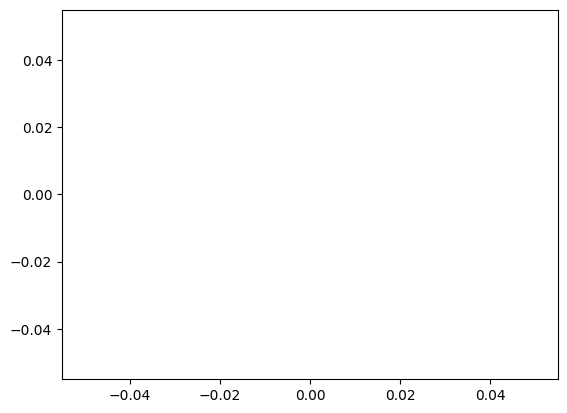

In [18]:
plt.plot(lossi)

In [3]:
for i in range(len(lossi)):
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {lossi.item():.4f}')


NameError: name 'lossi' is not defined

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) 
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.4863438606262207
val 2.509223699569702


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

arra.
amyah.
keer.
nah.
yal.
azthancendra.
galie.
adnelin.
aly.
jenlete.
avan.
aar.
kayziquena.
marsher.
rashirie.
ann.
jaxceon.
anthora.
uzzey.
daryy.


下面是改进版本

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])   # 10%


Xtr,  Ytr  = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte,  Yte  = Xte.to(device), Yte.to(device)

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [70]:
# 字符总数    embedimg layer  : input : vocab_size   out : n_embd
vocab_size = len(itos)
n_embd = 10

# 隐藏层神经元的个数
n_hidden = 200
# W (input , out = n_Neuron)
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden, generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device)
b2 = torch.randn(vocab_size, generator=g).to(device)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True



In [71]:
max_steps = 20000
batch_size = 512
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]  # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 200)
  logits = h @ W2 + b2  # (32, 27)
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 5000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())
    # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/  20000: 25.8422
   1000/  20000: 3.4076
   2000/  20000: 2.6777
   3000/  20000: 2.4958
   4000/  20000: 2.3522
   5000/  20000: 2.3627
   6000/  20000: 2.3668
   7000/  20000: 2.3703
   8000/  20000: 2.3833
   9000/  20000: 2.4767
  10000/  20000: 2.4377
  11000/  20000: 2.3595
  12000/  20000: 2.3089
  13000/  20000: 2.4042
  14000/  20000: 2.4572
  15000/  20000: 2.3796
  16000/  20000: 2.3721
  17000/  20000: 2.2799
  18000/  20000: 2.4224
  19000/  20000: 2.2913


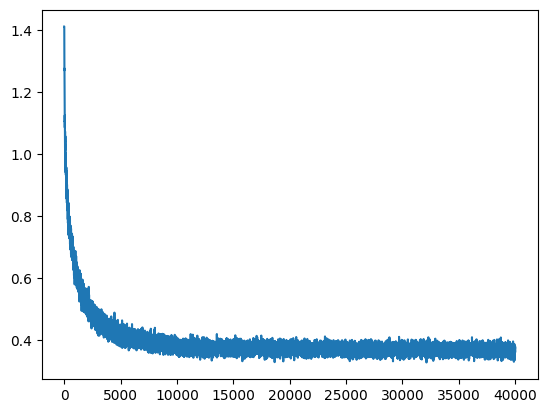

In [72]:
plt.plot(lossi)

In [74]:
# loss = -probs[torch.arange(num),ys].log().mean()  其实就是 预测下个值是ys的概率   mean 多个样本
# 假设没有先验信息, 下个值是ys的概率 应该是 1/27         多个样本的平均也是 1/27
# loss = -1/27.log()  == 3.2958
loss = -torch.tensor(1/27.0).log()  #

tensor(3.2958)

In [ ]:
# 而我们通过正态分布 得到的 loss = 25  显然是初始权重W b 设置不合理   导致前面的多次训练 其实没有优化
# 初始时:
#   1. logits = h @ W2 + b2    给出的分布差异过大   正态
#     (1) b2 随机导致的   b2 = 0
#     (2) 正态分布 不够矮胖(平均)  矮胖化   W2 = W2*0.01
#     (3) logits 为什么不能是平均即  W2 = b2 = 0

#   2. h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  h 经过 tanh 后 大多数值是 1 -1 分布是 两边高 中间比较平
#   本质 emb @ W1 + b1 是正态分布 均值是 b   太矮胖  我们需要 均值是0, 大多数值 在 (-1 1) 的高瘦的正态分布
#     (1) b = 0
#     (3)

In [80]:
logits = torch.randn(4)
probs = torch.softmax(logits,dim=0);
loss = -probs[2].log()
logits,probs,loss

(tensor([-0.7382, -0.8575, -1.3519, -0.8741]),
 tensor([0.3029, 0.2688, 0.1640, 0.2644]),
 tensor(1.8082))

In [79]:


@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]  # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2  # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')


train 2.3349530696868896
val 2.3489842414855957


In [15]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size  # initialize with all ...
  while True:
    emb = C[torch.tensor([context])]  # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)